In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

sys.path.insert(0, os.path.abspath('../src'))

from models.heston import HestonModel

plt.style.use('seaborn-v0_8-darkgrid')
print("Setup complete.")

Setup complete.


In [8]:
# NEGATIVE rho to see the leverage effect
heston_params = {
    'S0': 100,
    'mu': 0.05,
    'v0': 0.04,        # Initial variance (v0=0.04 -> vol=sqrt(0.04)=0.2 or 20%)
    'kappa': 3.0,      # Mean-reversion speed
    'theta': 0.09,     # Long-term variance (vol=0.3 or 30%)
    'xi': 0.5,         # Vol of vol
    'rho': -0.7        # negative correlation
}

heston_model = HestonModel(**heston_params)
print(f"Model created: {heston_model}")

# Simulation settings
T = 3       # 3 years
dt = 1/252    # Daily steps
n_paths = 10

sim_paths, sim_vars = heston_model.simulate(T, dt, n_paths)

print(f"Path array shape: {sim_paths.shape}")
print(f"Variance array shape: {sim_vars.shape}")

Model created: HestonModel({'S0': 100, 'mu': 0.05, 'v0': 0.04, 'kappa': 3.0, 'theta': 0.09, 'xi': 0.5, 'rho': -0.7})
Path array shape: (757, 10)
Variance array shape: (757, 10)


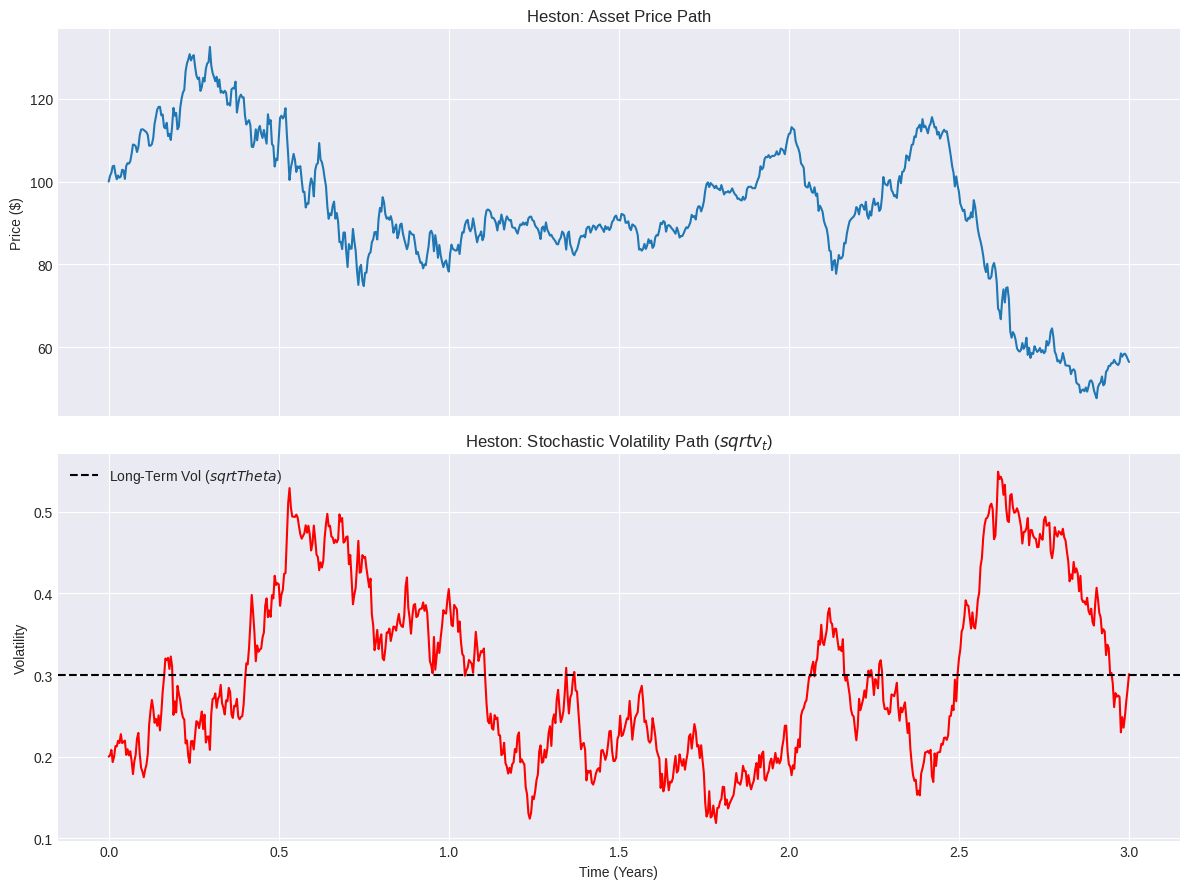

In [9]:
# Price vs. Volatility
# Plotting the first simulated path

path_idx = 0
price_path = sim_paths[:, path_idx]
vol_path = np.sqrt(sim_vars[:, path_idx]) # Convert variance to volatility
time_axis = np.linspace(0, T, sim_paths.shape[0])

# Create two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(12, 9), 
    sharex=True
)

# --- Top Plot: Asset Price ---
ax1.plot(time_axis, price_path)
ax1.set_title("Heston: Asset Price Path")
ax1.set_ylabel("Price ($)")

# --- Bottom Plot: Volatility ---
ax2.plot(time_axis, vol_path, color='red')
ax2.set_title("Heston: Stochastic Volatility Path ($sqrt{v_t}$)")
ax2.set_ylabel("Volatility")
ax2.set_xlabel("Time (Years)")

# Plot long-term mean vol
ax2.axhline(
    np.sqrt(heston_params['theta']), 
    color='black', 
    linestyle='--', 
    label=f"Long-Term Vol ($sqrt{{Theta}}$)"
)
ax2.legend()

plt.tight_layout()
plt.show()

# 1. Volatility Clustering:
#    Notice how the red line has phases where it becomes really "spiky"
#    followed by calm stretches — this pattern is called volatility clustering.
# 2. Leverage Effect:
#    Whenever there’s a sharp drop in the price (top plot),
#    you’ll usually see a sudden spike in volatility (bottom plot)
#    around the same time. That’s the leverage effect in action.

Running validation for autocorrelation...


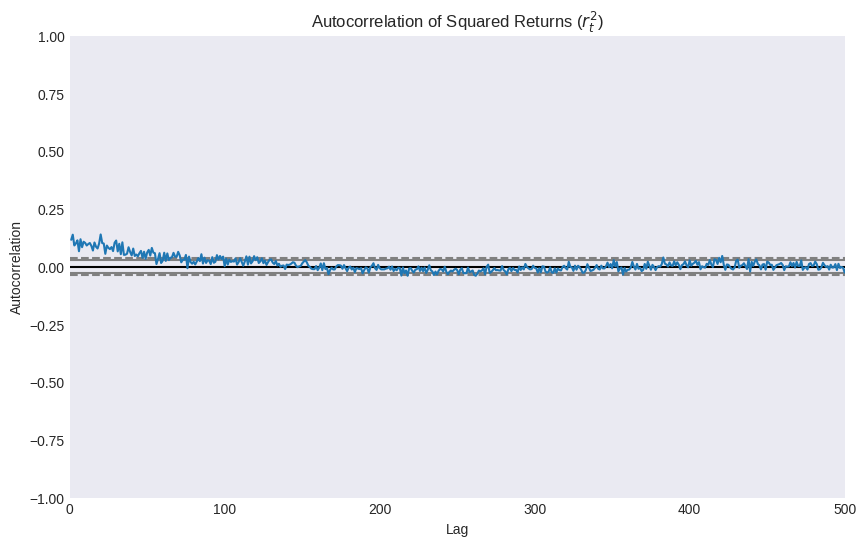

In [5]:
# Validation - Autocorrelation of Returns
# This is the statistical proof of volatility clustering.
# Single, long path.

print("Running validation for autocorrelation...")
T_long = 20
long_path, long_vars = heston_model.simulate(T_long, dt, n_paths=1)

# Get log returns
log_returns = np.log(long_path[1:, 0] / long_path[:-1, 0])

# SQUARED log returns
squared_log_returns = log_returns**2

# Plot the autocorrelation
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
# autocorrelation_plot(squared_log_returns)
ax = autocorrelation_plot(squared_log_returns)

# Setting the x-axis limit to only show the first 500 lags
ax.set_xlim([0, 500])

plt.title("Autocorrelation of Squared Returns ($r_t^2$)")
plt.xlabel("Lag")
plt.show()

# For Heston, we should see a clear, positive autocorrelation
# for the first few lags, which then decays.
# This proves that a high (squared) return today
# makes a high (squared) return tomorrow more likely.
# This is the definition of volatility clustering.